<a href="https://colab.research.google.com/github/ilhamazhar1308/Machine-Learning-Based-Sonic-Log-Prediction-Using-Multi-Well-Data/blob/main/Machine_Learning%E2%80%93Based_Sonic_Log_Prediction_Using_Multi_Well_Well_Log_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

# Install and import LAS file reader
!pip install lasio
import lasio


In [41]:
DATA_PATH = "/content"
REQUIRED_LOGS = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'DT']

las_files = sorted(glob.glob(os.path.join(DATA_PATH, "*.LAS")))
print(f"Number of LAS files found: {len(las_files)}")

processed_wells = {}

for f in las_files:
    las = lasio.read(f)
    df = las.df().reset_index()
    well_name = os.path.basename(f)

    # Check whether all required logs are available
    if all(log in df.columns for log in REQUIRED_LOGS):
        df = df[['DEPTH'] + REQUIRED_LOGS].dropna()
        processed_wells[well_name] = df
    else:
        print(f"⚠️ Incomplete logs in well {well_name}, skipped")

print(f"Number of usable wells: {len(processed_wells)}")


Number of LAS files found: 2
Number of usable wells: 2


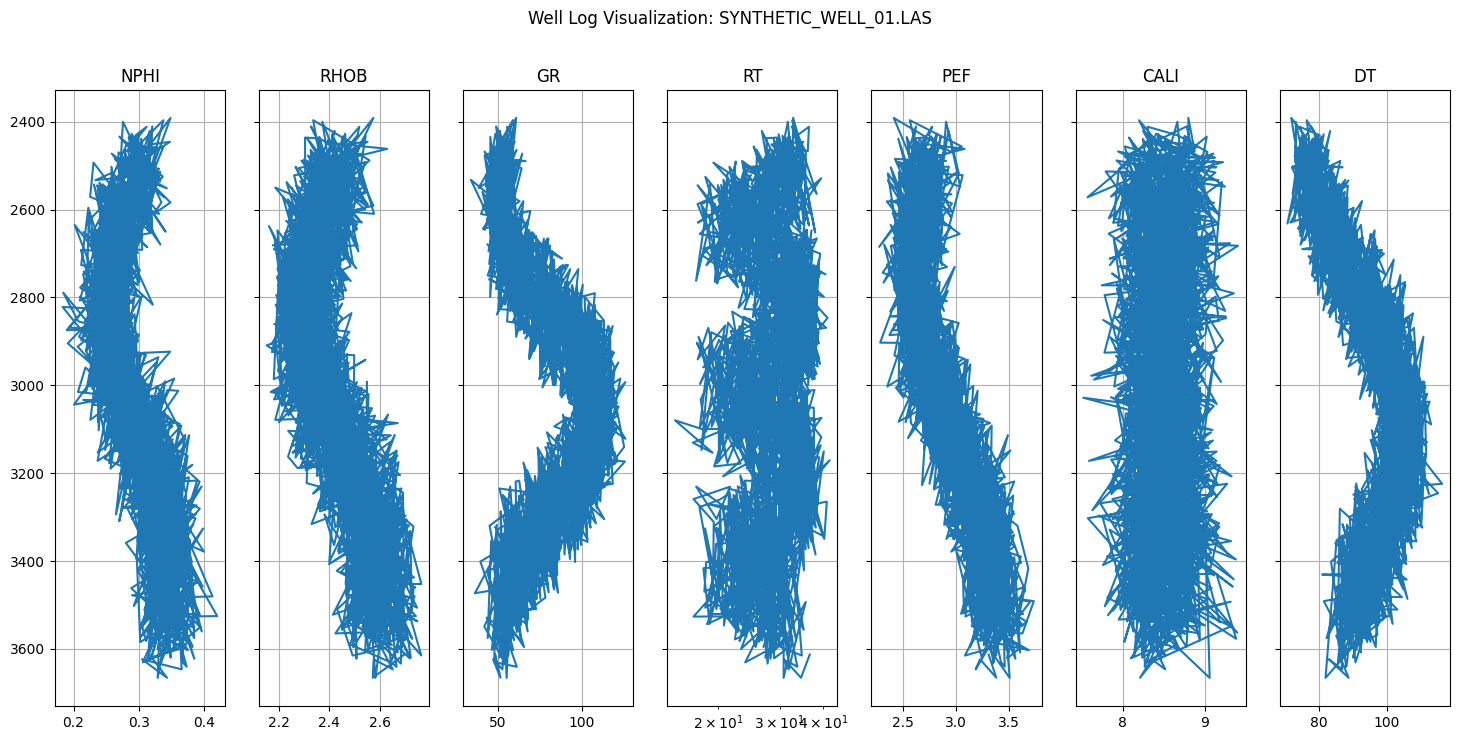

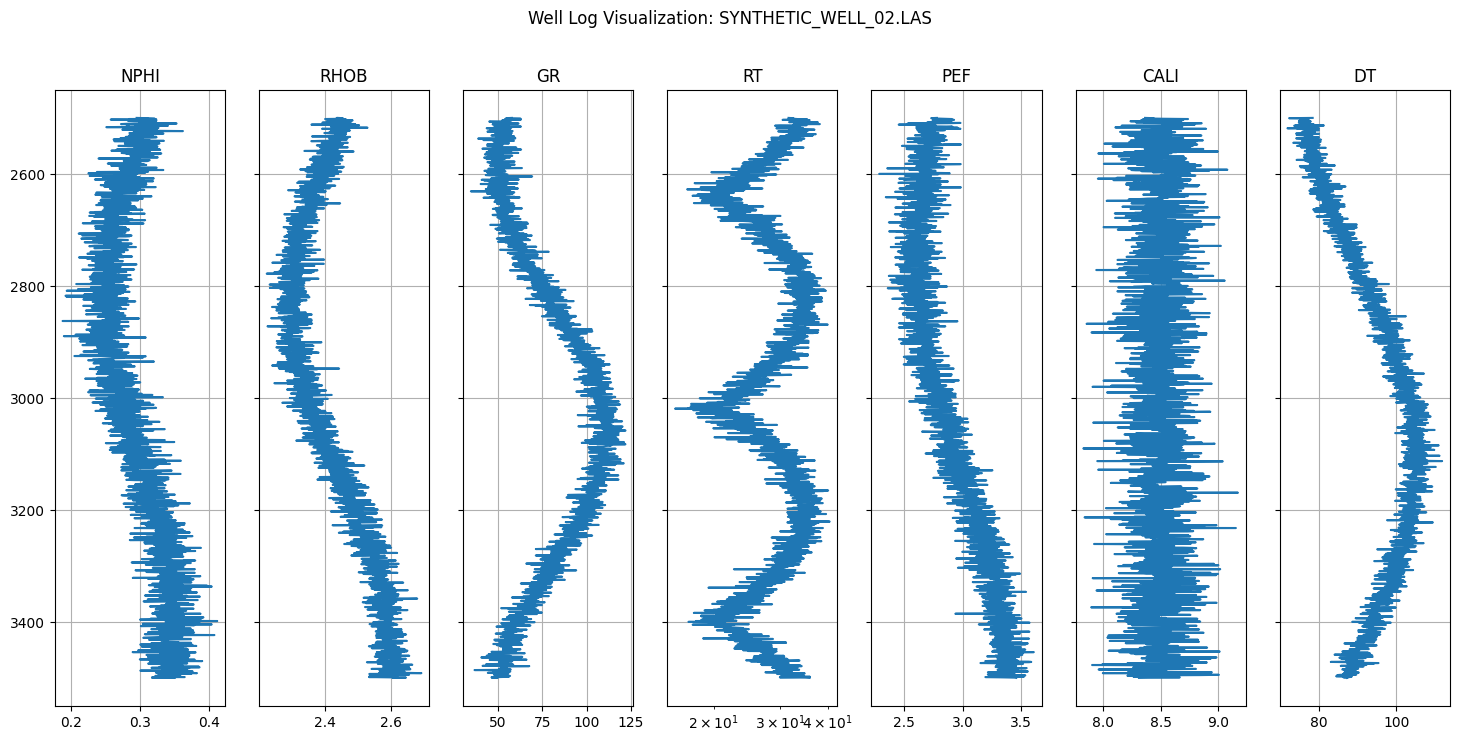

In [42]:
def plot_logs(df, logs, name):
    fig, ax = plt.subplots(1, len(logs), figsize=(18,8), sharey=True)
    for i, log in enumerate(logs):
        if log == 'RT':
            ax[i].semilogx(df[log], df['DEPTH'])
        else:
            ax[i].plot(df[log], df['DEPTH'])
        ax[i].invert_yaxis()
        ax[i].set_title(log)
        ax[i].grid()
    fig.suptitle(f"Well Log Visualization: {name}")
    plt.show()

for name, df in processed_wells.items():
    plot_logs(df, REQUIRED_LOGS, name)


In [43]:
well_names = list(processed_wells.keys())

if len(well_names) < 2:
    raise ValueError("At least two wells are required for training and testing")

train_wells, test_wells = train_test_split(
    well_names, test_size=0.3, random_state=42
)

train_df = pd.concat([processed_wells[w] for w in train_wells])
test_df  = pd.concat([processed_wells[w] for w in test_wells])

features = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI']
target = 'DT'


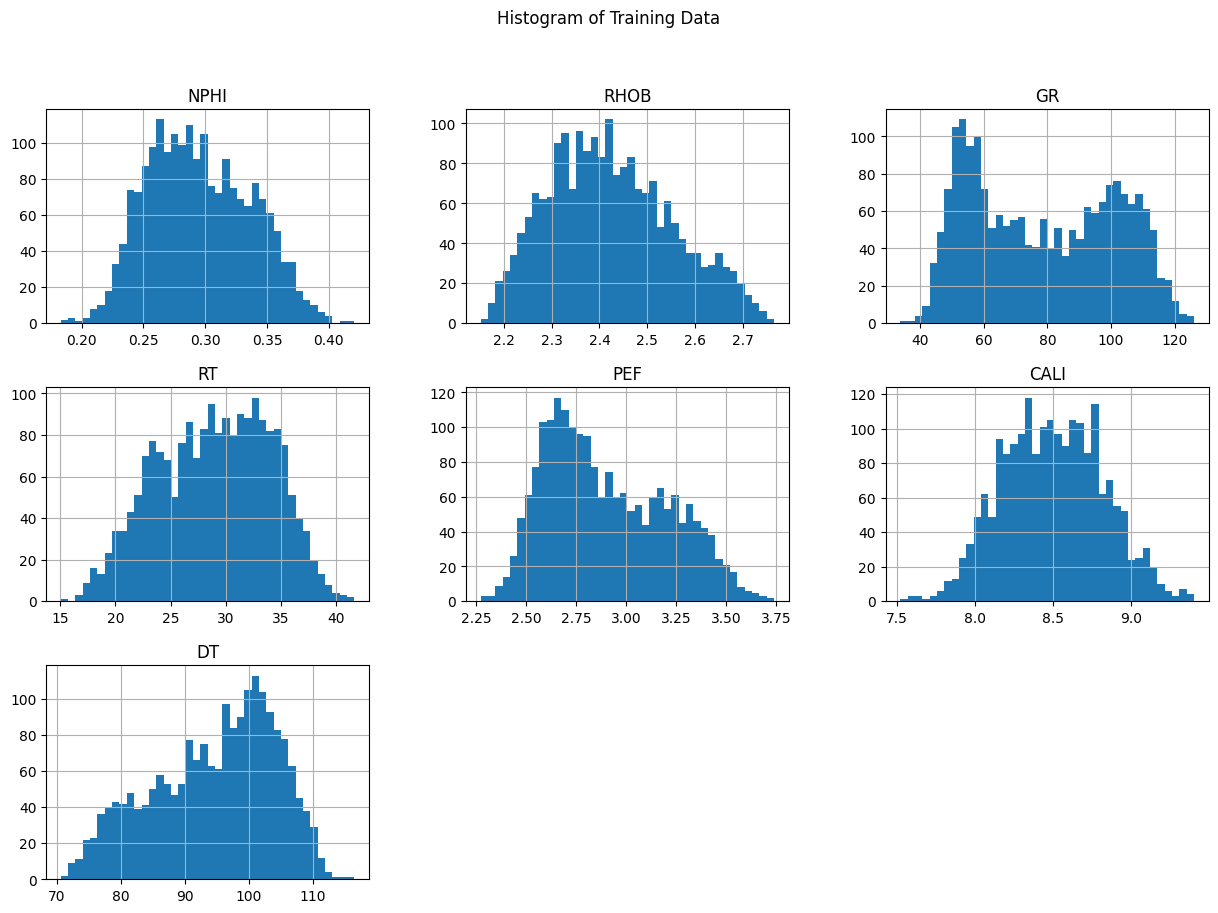

In [44]:
train_df[features + [target]].hist(bins=40, figsize=(15,10))
plt.suptitle("Histogram of Training Data")
plt.show()


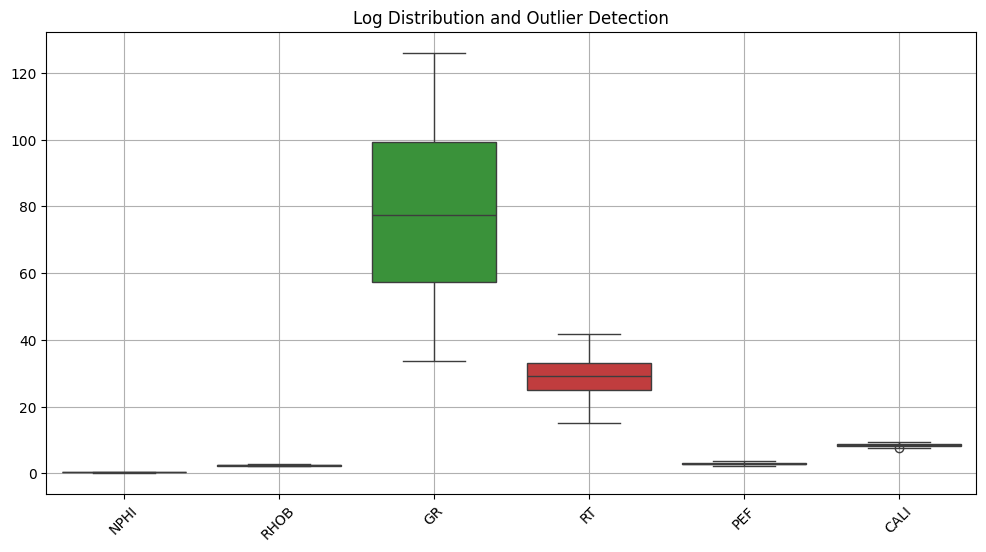

In [45]:
plt.figure(figsize=(12,6))
sns.boxplot(data=train_df[features])
plt.title("Log Distribution and Outlier Detection")
plt.xticks(rotation=45)
plt.grid()
plt.show()


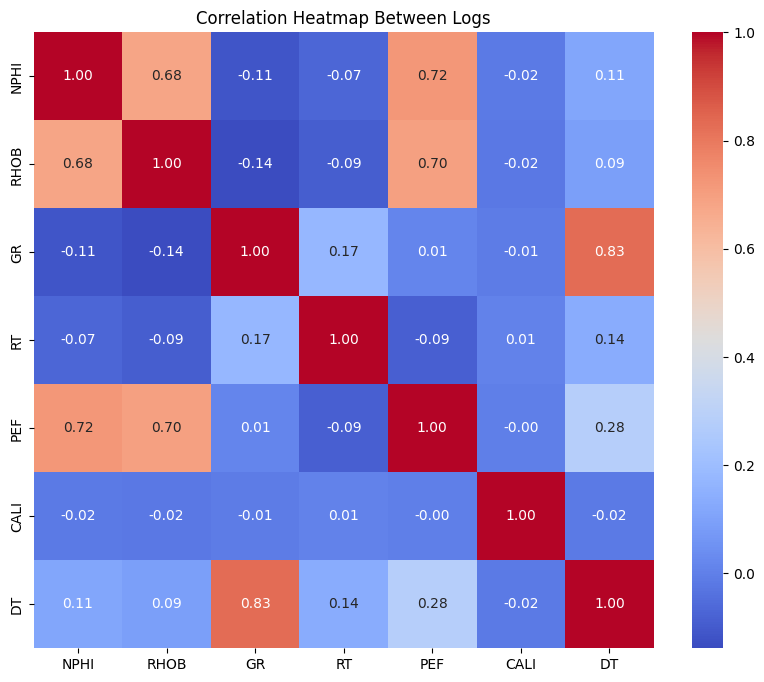

In [46]:
plt.figure(figsize=(10,8))
sns.heatmap(
    train_df[features + [target]].corr(),
    annot=True, cmap='coolwarm', fmt=".2f"
)
plt.title("Correlation Heatmap Between Logs")
plt.show()


In [47]:
Q1 = train_df[features].quantile(0.25)
Q3 = train_df[features].quantile(0.75)
IQR = Q3 - Q1

mask = ~((train_df[features] < (Q1 - 1.5 * IQR)) |
         (train_df[features] > (Q3 + 1.5 * IQR))).any(axis=1)

train_df = train_df[mask]


In [48]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train = scaler_X.fit_transform(train_df[features])
y_train = scaler_y.fit_transform(train_df[[target]])

X_test = scaler_X.transform(test_df[features])
y_test = scaler_y.transform(test_df[[target]])


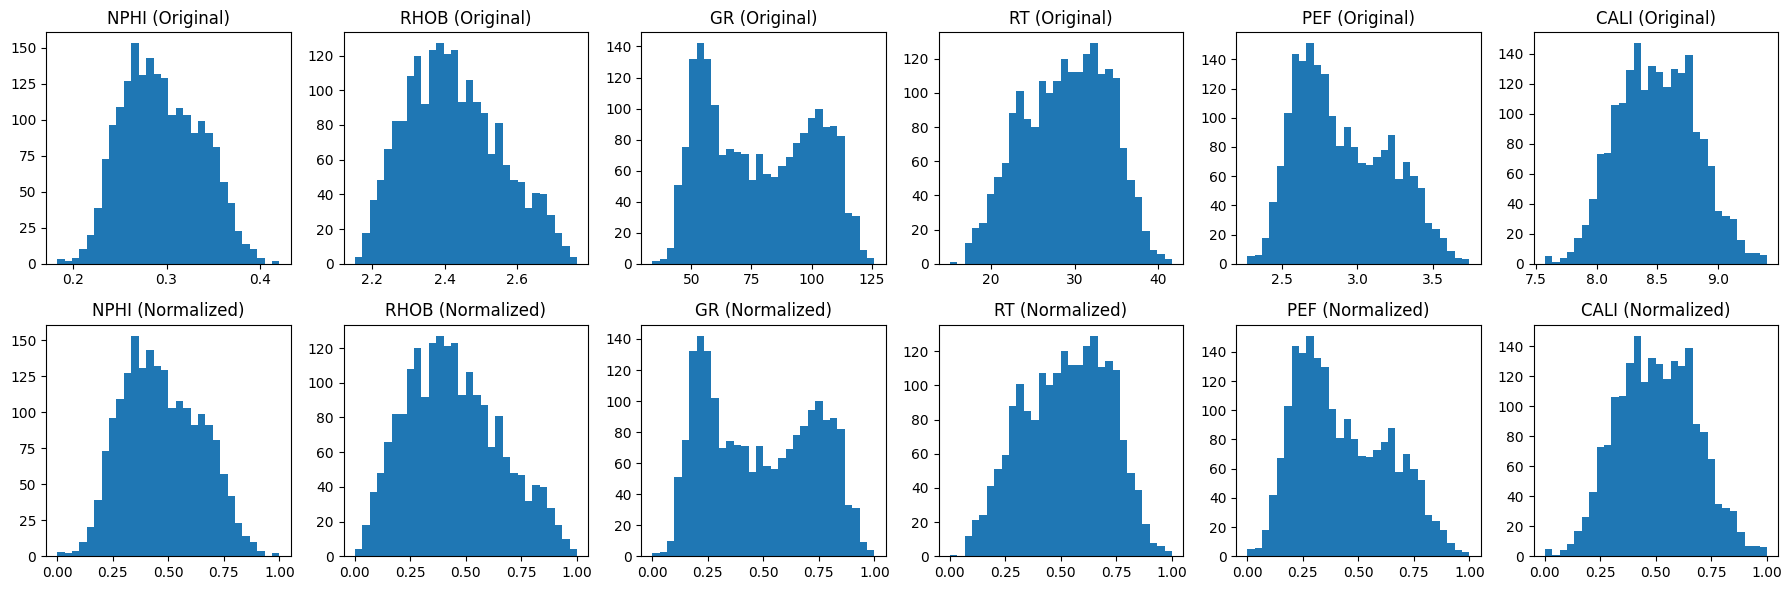

In [49]:
fig, ax = plt.subplots(2, len(features), figsize=(18,6))
for i, f in enumerate(features):
    ax[0,i].hist(train_df[f], bins=30)
    ax[0,i].set_title(f"{f} (Original)")
    ax[1,i].hist(X_train[:,i], bins=30)
    ax[1,i].set_title(f"{f} (Normalized)")
plt.tight_layout()
plt.show()


In [50]:
model = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train.ravel())


RandomForestRegressor(n_estimators=300, n_jobs=-1, random_state=42)

In [51]:
y_pred = model.predict(X_test)

print("R² Score :", r2_score(y_test, y_pred))
print("RMSE     :", np.sqrt(mean_squared_error(y_test, y_pred)))


R² Score : 0.9237516046346523
RMSE     : 0.05512156705201419


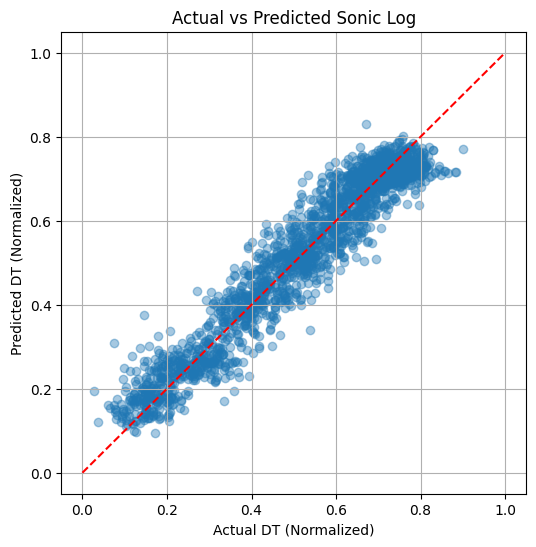

In [52]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.4)
plt.plot([0,1],[0,1],'r--')
plt.xlabel("Actual DT (Normalized)")
plt.ylabel("Predicted DT (Normalized)")
plt.title("Actual vs Predicted Sonic Log")
plt.grid()
plt.show()


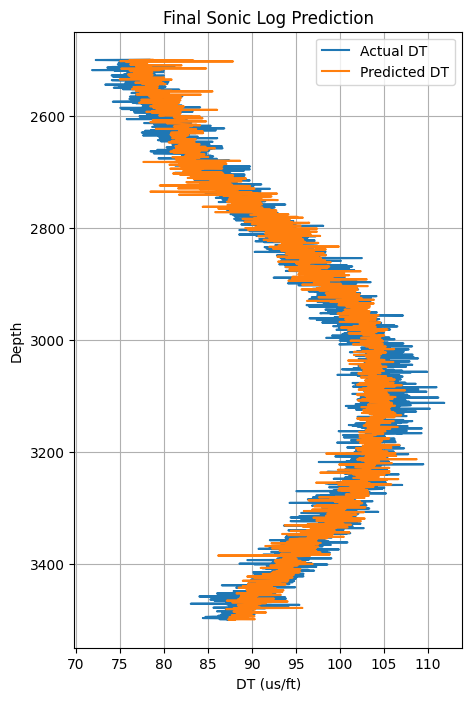

In [53]:
test_df = test_df.copy()
test_df['DT_PRED'] = scaler_y.inverse_transform(
    y_pred.reshape(-1,1)
)

plt.figure(figsize=(5,8))
plt.plot(test_df['DT'], test_df['DEPTH'], label='Actual DT')
plt.plot(test_df['DT_PRED'], test_df['DEPTH'], label='Predicted DT')
plt.gca().invert_yaxis()
plt.xlabel("DT (us/ft)")
plt.ylabel("Depth")
plt.title("Final Sonic Log Prediction")
plt.legend()
plt.grid()
plt.show()
